In [1]:
from hossam import *
from pandas import DataFrame, Series
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from itertools import product

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler

# 성능 평가 지표 모듈
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

# 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor

import sys

sys.path.append("/Users/jinwoo/Machine_Learning")

from hs_eval_utils import (
    hs_get_scores,
    hs_learning_cv,
    hs_get_score_cv,
    feature_importance,
    hs_shap_analysis,
)

from sklearn.tree import DecisionTreeRegressor

import shap

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

from catboost import CatBoostRegressor

In [2]:
origin = load_data("restaurant_sales_preprocessed")
origin.set_index("date", inplace=True)
origin["holiday"] = origin["holiday"].astype("category")
origin["weekend"] = origin["weekend"].astype("category")
origin.info()

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
<class 'pandas.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sales           353 non-null    float64 
 1   visitors        353 non-null    int64   
 2   avg_price       353 non-null    int64   
 3   marketing_cost  353 non-null    float64 
 4   delivery_ratio  353 non-null    float64 
 5   rain_mm         353 non-null    float64 
 6   temperature     353 non-null    float64 
 7   holiday         353 non-null    category
 8   weekend         353 non-null    category
dtypes: category(2), float64(5), int64(2)
memory usage: 22.8 KB


In [3]:
df = origin
yname = "sales"
x = df.drop(columns=[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 8), (89, 8), (264,), (89,))

In [4]:
base_model = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    cat_features=["weekend", "holiday"],
    random_state=52,
    logging_level="Silent",
)

param_grid = {
    "iterations": [300, 500],
    "learning_rate": [0.01, 0.03, 0.1],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [1, 3, 5],
    "subsample": [0.8, 1.0],
}

gs = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

gs.fit(x_train, y_train)

best_model = gs.best_estimator_
best_model

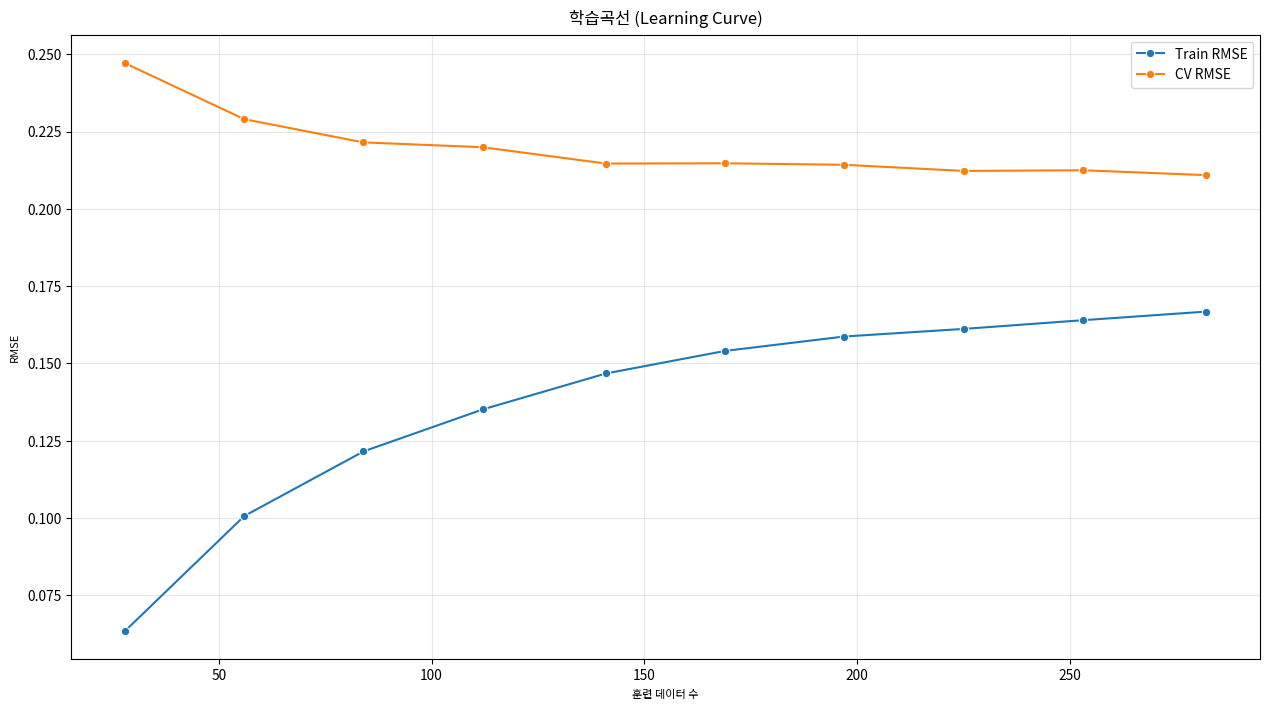

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
CatBoostRegressor,0.815,0.131,0.027,0.164,0.008,-0.011,0.167,0.211,0.013,0.791,0.063,⚠️ 과대적합 (variance 큼)


In [5]:
hs_get_score_cv(best_model, x_train, y_train, x, y)

In [11]:
imp = best_model.get_feature_importance(type="FeatureImportance")
imp_df = DataFrame({"importance": imp}, index=best_model.feature_names_)

# 비율 + 누적합
imp_df["ratio"] = imp_df["importance"] / imp_df["importance"].sum()

imp_df = imp_df.sort_values("importance", ascending=False)
imp_df["cumsum"] = imp_df["ratio"].cumsum()

imp_df

,importance,ratio,cumsum
weekend,31.444,0.314,0.314
holiday,29.792,0.298,0.612
marketing_cost,14.875,0.149,0.761
rain_mm,8.319,0.083,0.844
avg_price,8.058,0.081,0.925
visitors,3.741,0.037,0.962
temperature,2.283,0.023,0.985
delivery_ratio,1.488,0.015,1.000


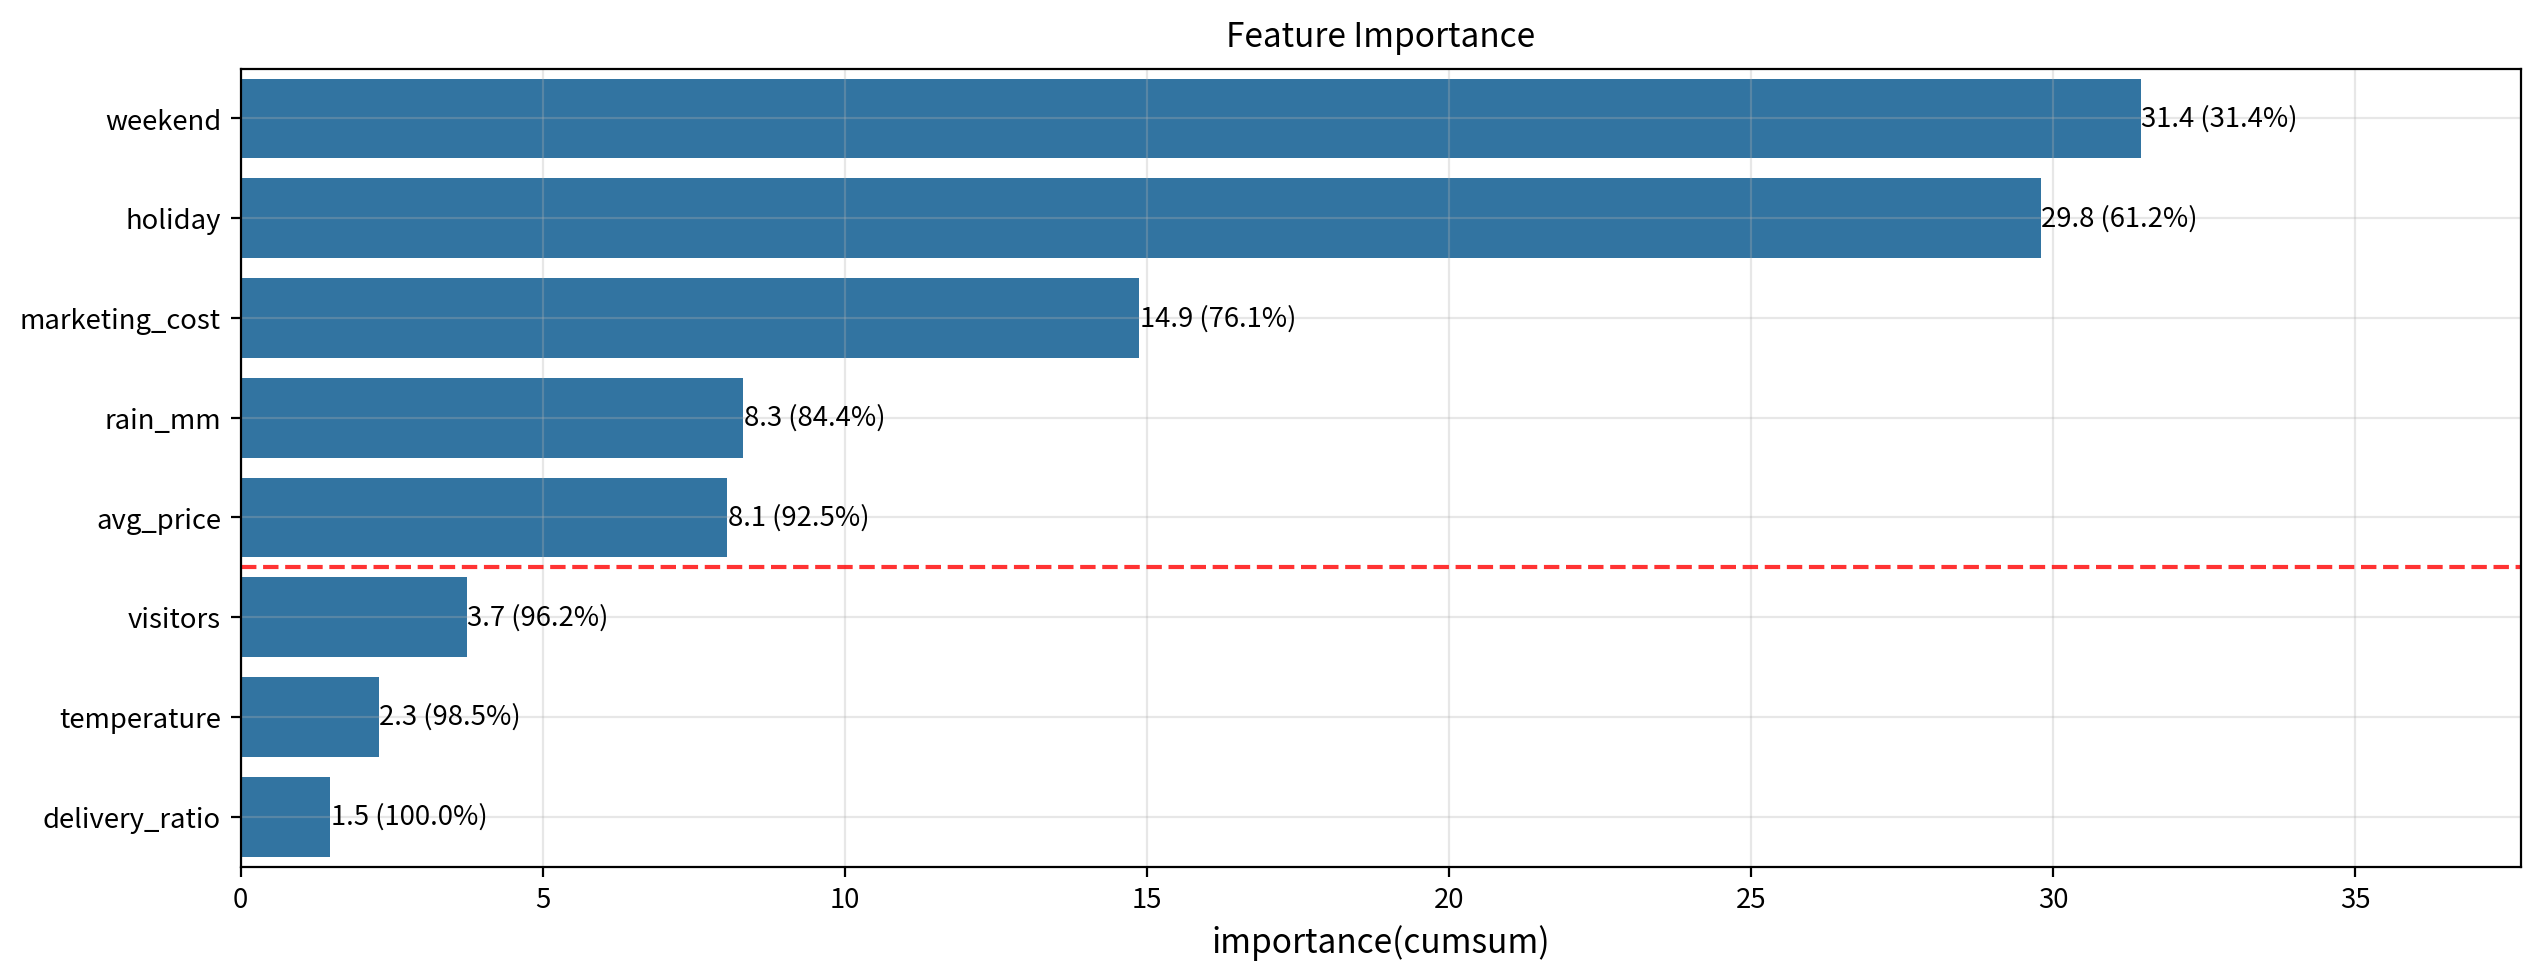

In [12]:
df = imp_df.sort_values(by="ratio", ascending=False)
threshold = 0.9

figsize = (1280 / 100, 500 / 100)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.barplot(data=df, x="importance", y=df.index)

# 값 라벨 추가
for i, v in enumerate(imp_df["importance"]):
    ax.text(
        v + 0.005,  # 막대 끝에서 약간 오른쪽
        i,  # y 위치
        f"{v:.1f} ({imp_df.iloc[i]['cumsum']*100:.1f}%)",  # 표시 형식
        va="center",
    )

ax.set_title("Feature Importance", fontsize=12, pad=8)
ax.set_xlabel("importance(cumsum)", fontsize=12)
ax.set_ylabel(None)
ax.grid(True, alpha=0.3)

ax.set_xlim(0, imp_df["importance"].max() * 1.2)

# 90% 처음 도달하는 인덱스 (0-based)
cut_idx = np.argmax(imp_df["cumsum"].values >= threshold)

# 주황색 rank 기준으로 +1
cut_rank = (int(cut_idx) + 1) - 0.5

# 90% 도달 지점 수직선 (핵심)
plt.axhline(
    y=cut_rank,
    linestyle="--",
    color="red",
    alpha=0.8,
)

plt.tight_layout()
plt.show()
plt.close()

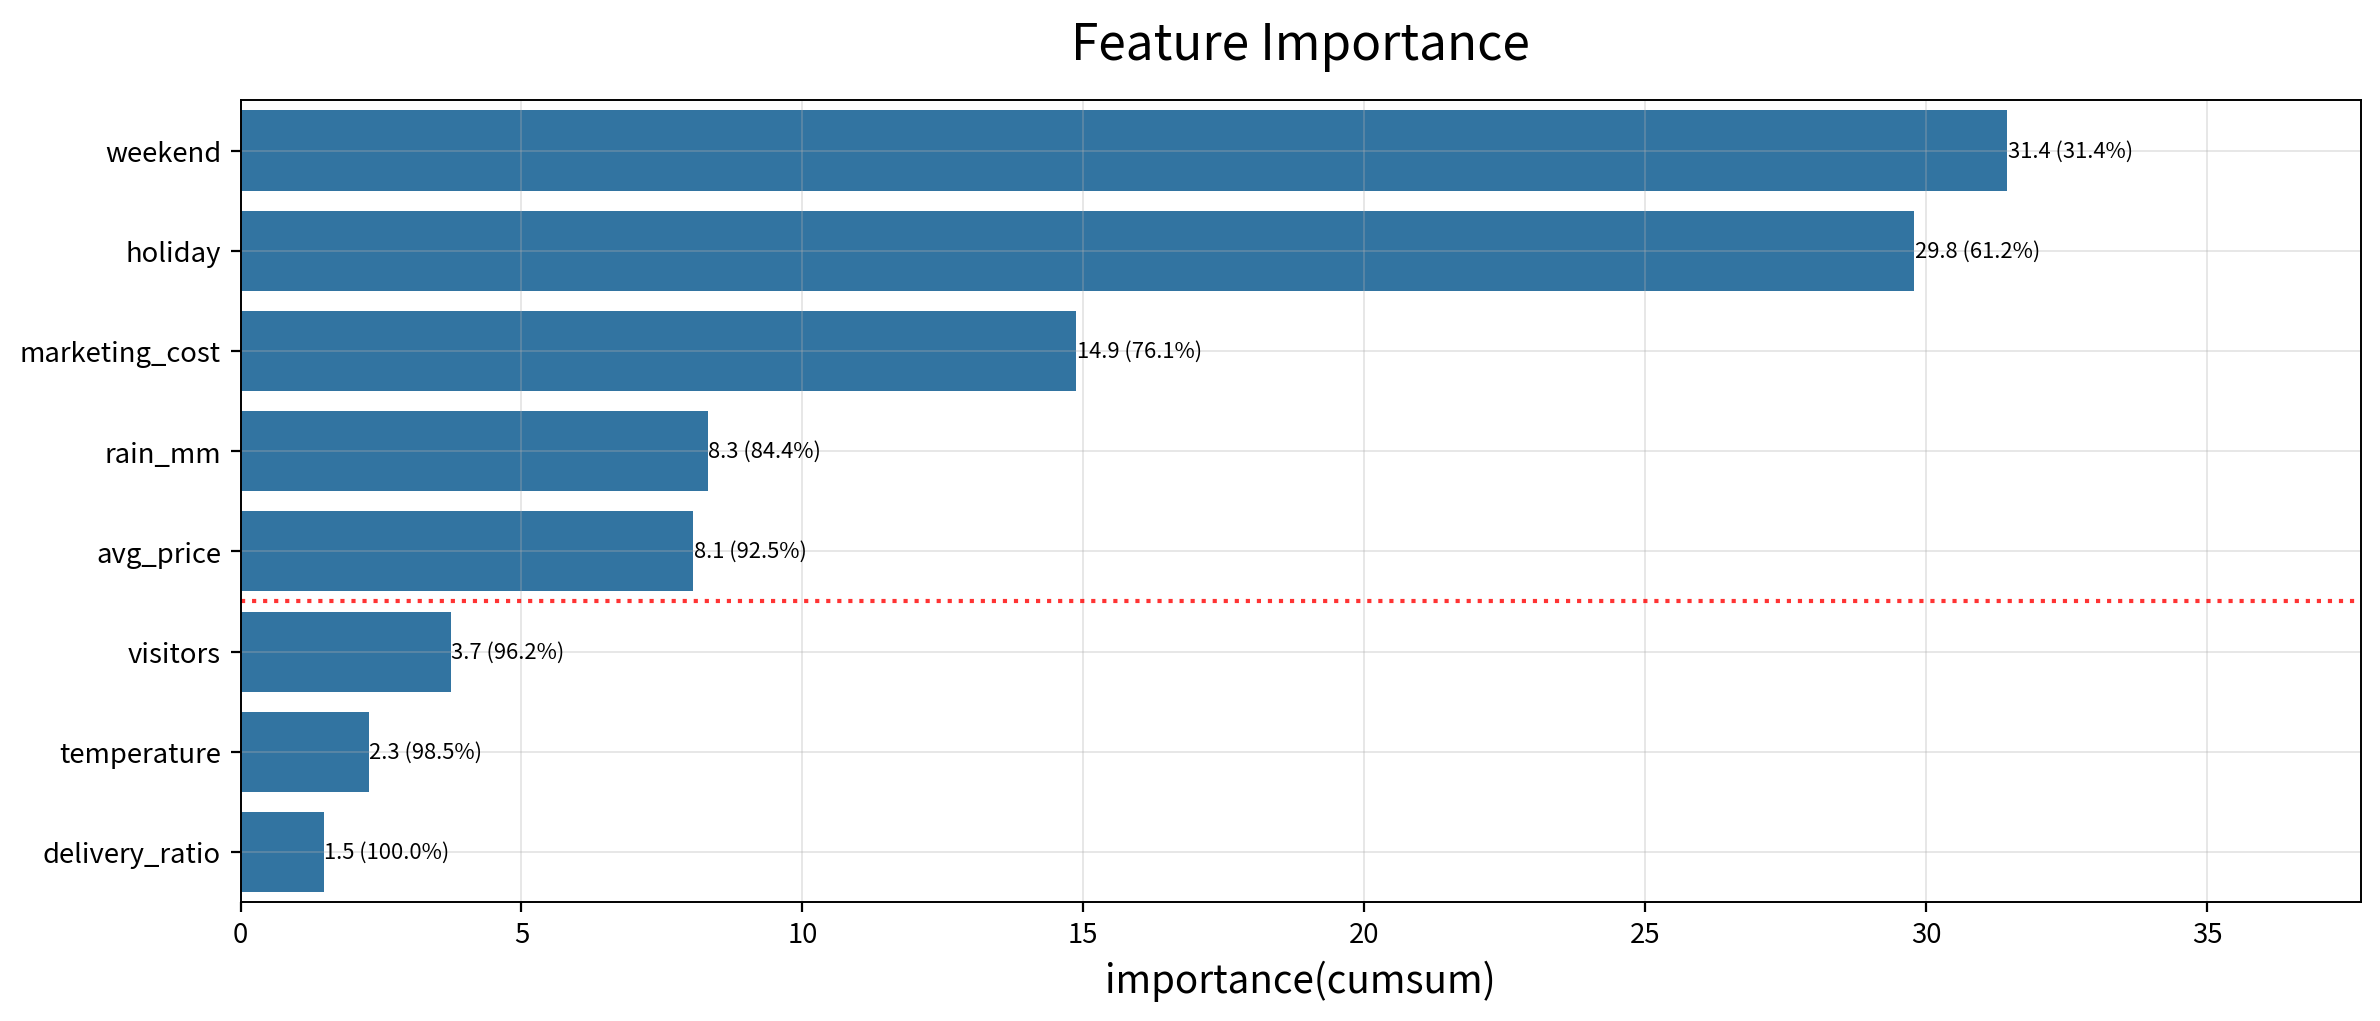

,importance,ratio,cumsum
weekend,31.444,0.314,0.314
holiday,29.792,0.298,0.612
marketing_cost,14.875,0.149,0.761
rain_mm,8.319,0.083,0.844
avg_price,8.058,0.081,0.925
visitors,3.741,0.037,0.962
temperature,2.283,0.023,0.985
delivery_ratio,1.488,0.015,1.000


In [13]:
hs_feature_importance(best_model, x_train, y_train)

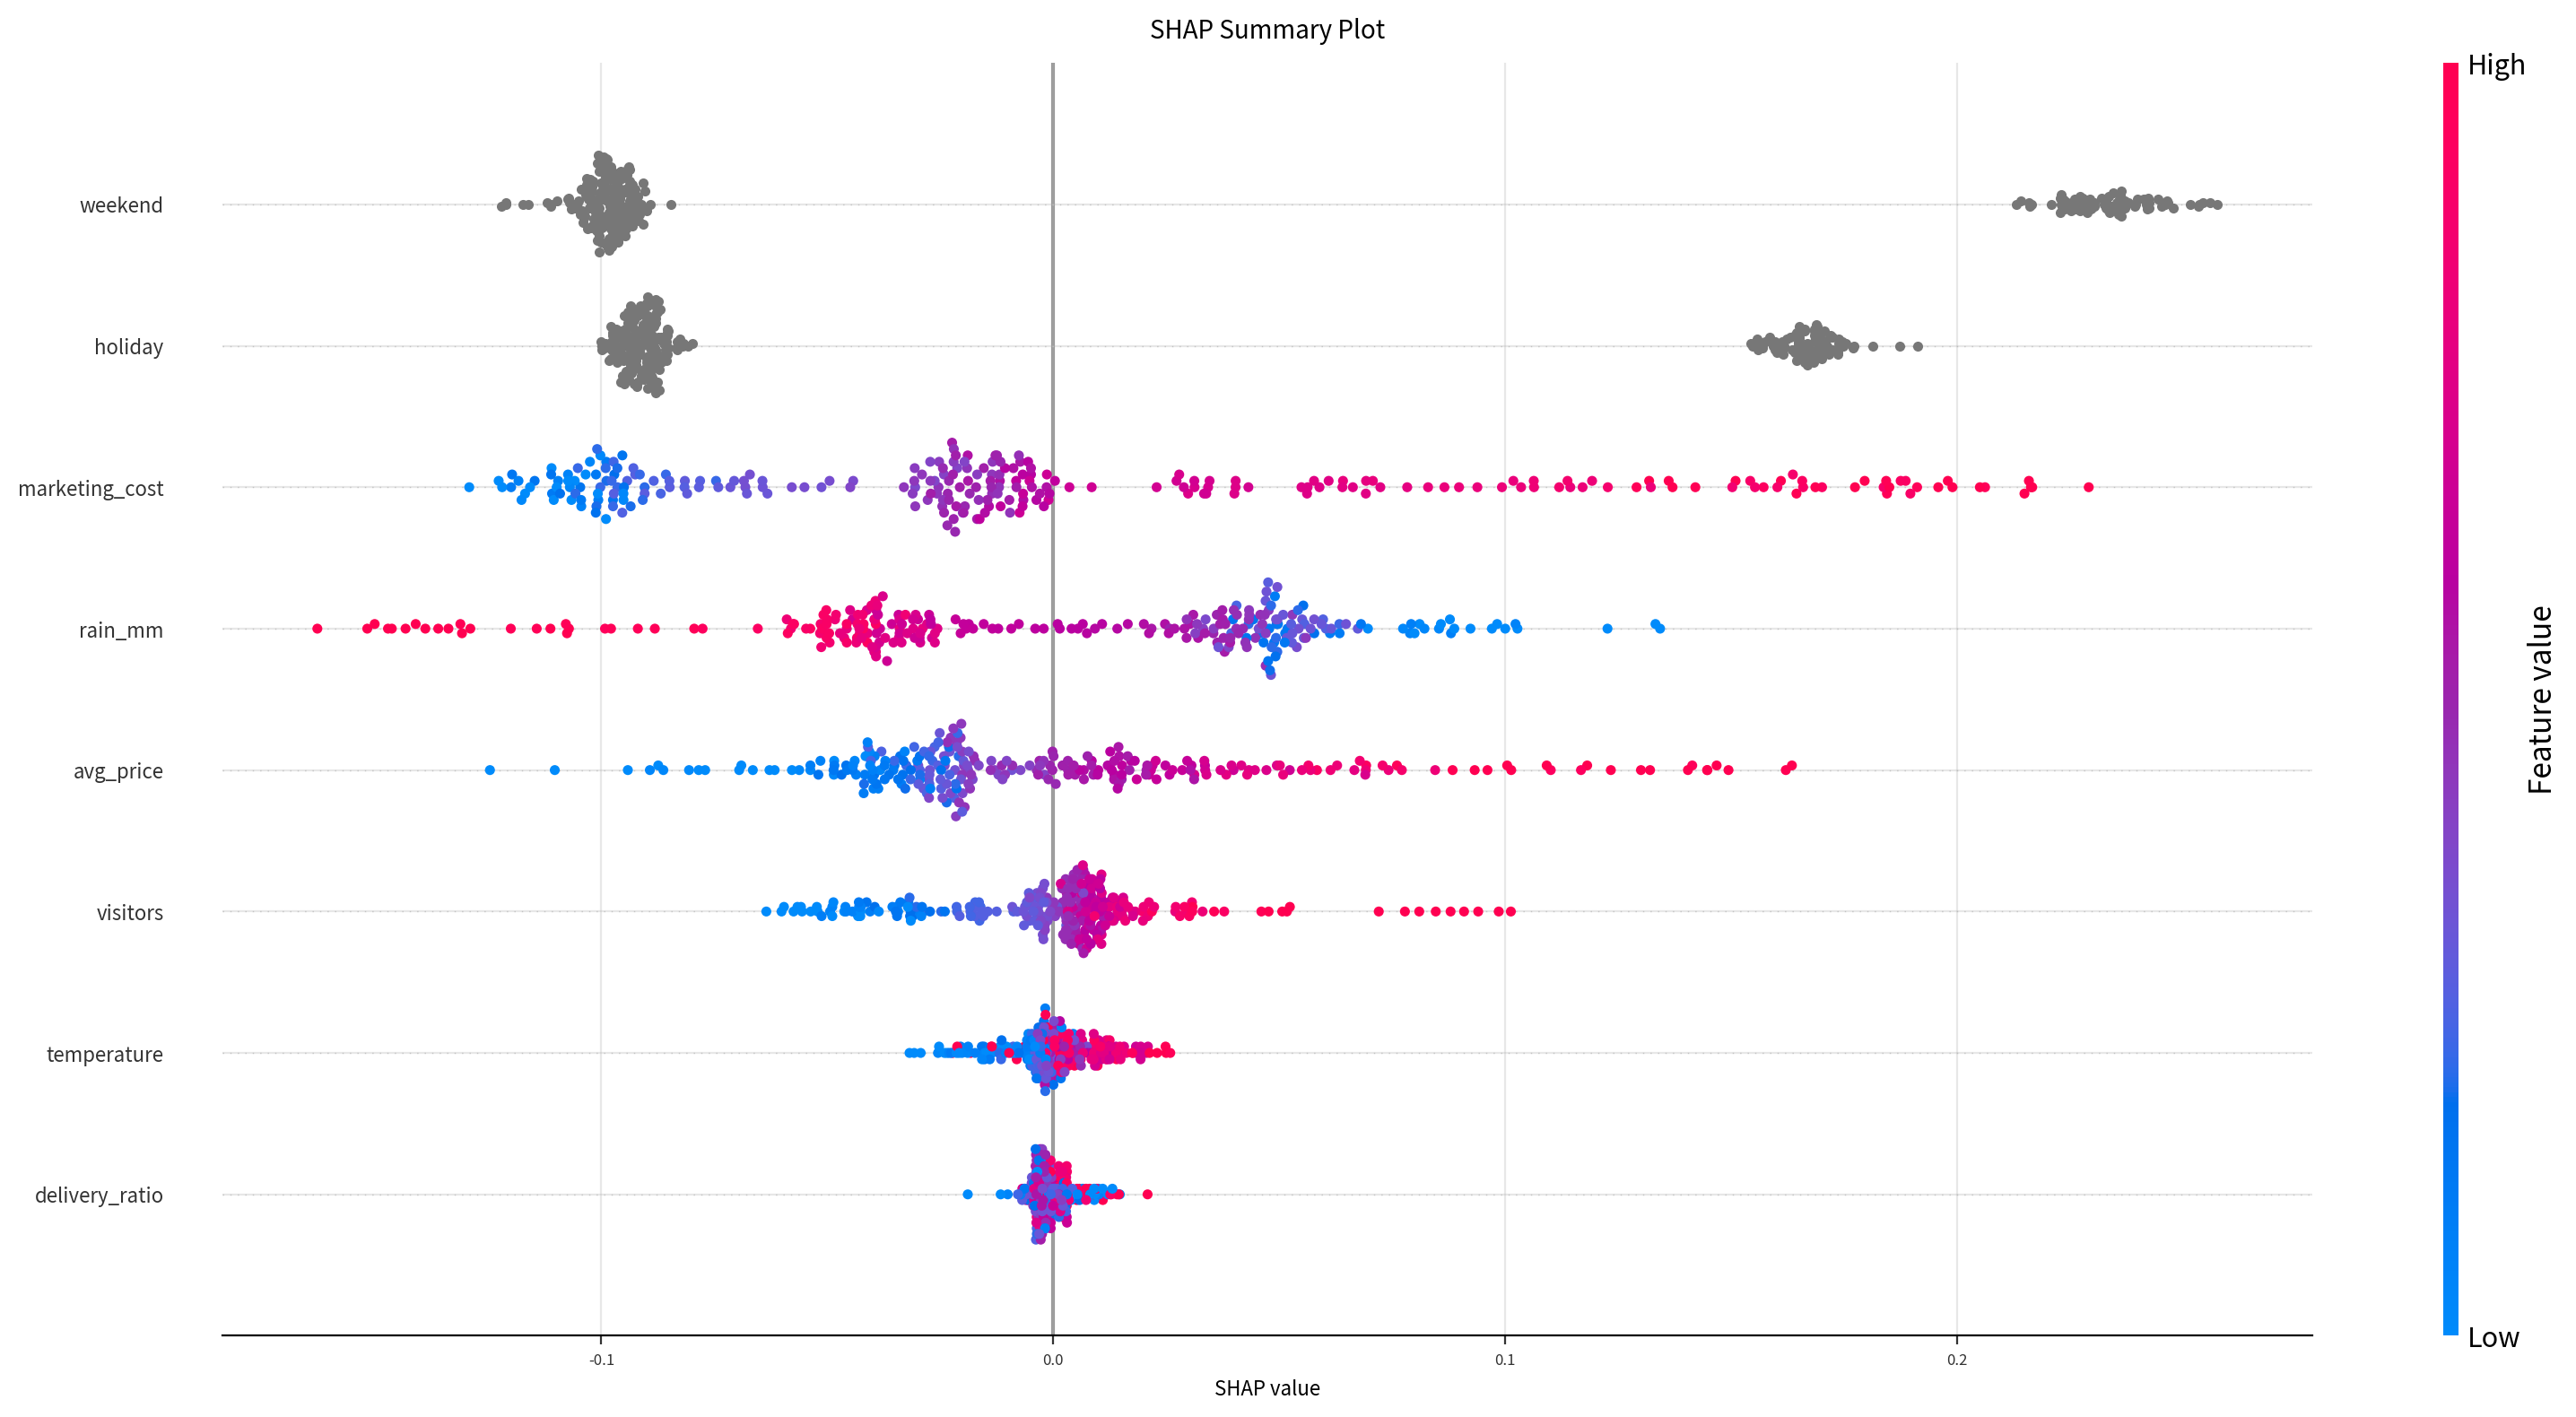

In [14]:
summary_df, shap_values = hs_shap_analysis(best_model, x_train)